In [506]:
import tifffile
import numpy as np
from tqdm import tqdm
from pathlib import Path
import os
import sys
from matplotlib import pyplot as plt
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
import dbtools.dbtools as db
import dbtools.load as load
from preprocess_tools import io, signal

# Database conection

In [507]:
try:
    conn = db.connect()
    print("Connected to the database")
except Exception as error:
    print(error)

Connected to the database


## Measurements file paths

In [508]:
original_path = Path(r"\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\lente\probetas\Na_07_5\Na_07_5.tif")

measurements_table = db.relation_metadata('measurements','samples','sample_measurements')

parent_id_column = 'measurementtype_id_measurement'

saving_folder = Path(str(original_path).replace('.tif','attenuation_Cscan.tif'))

original_path_str = str(original_path)
original_id = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, 'id_measurement'].values
original_measurementtype_id = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, parent_id_column].values[0]
original_sample_name = measurements_table.loc[measurements_table['file_path_measurement'] == original_path_str, 'name_sample'].values
original_id=original_id
original_measurementtype_id=original_measurementtype_id
original_sample_name=original_sample_name
print(f"Original path: {original_path_str}, ID: {original_id}", 
        f"Measurement type ID: {original_measurementtype_id}",
        f"Sample names: {original_sample_name}")

Original path: \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\lente\probetas\Na_07_5\Na_07_5.tif, ID: [332] Measurement type ID: 10 Sample names: ['Na_07_5']


In [509]:
print(f"Saving folder: {saving_folder}")

Saving folder: \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\lente\probetas\Na_07_5\Na_07_5attenuation_Cscan.tif


# Cscan

Aligning signal batches: 100%|██████████| 95/95 [00:00<00:00, 385.70it/s]


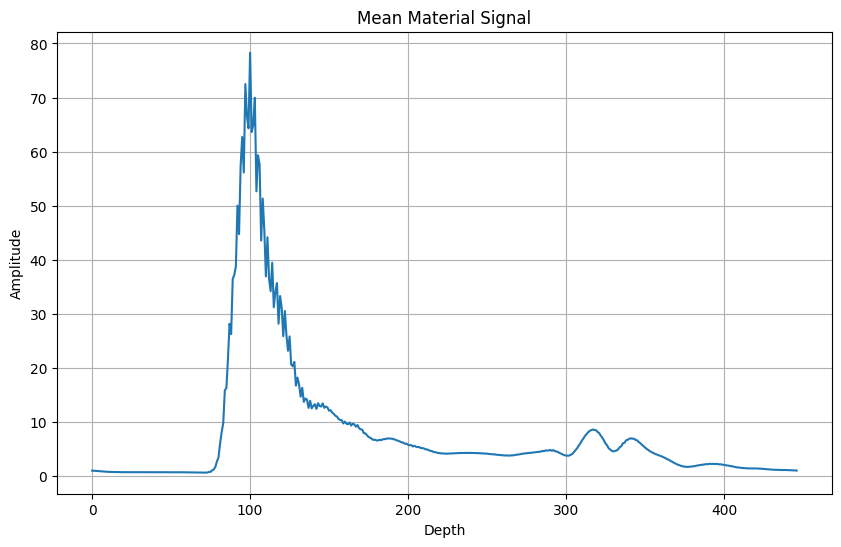

In [510]:
#load file
volume = io.load_tif(original_path)

#align signals
volume = np.swapaxes(volume,0,2)
volume_shape = volume.shape
volume = volume.reshape((volume_shape[0]*volume_shape[1],1, -1))
align_point = 100
volume = signal.align_signals_optimized(volume,point=align_point)
volume = volume.reshape(volume_shape)
volume = np.swapaxes(volume,0,2)

#generate envelope signal
envelope_volume = signal.envelope(volume, axis=0)

#detect signals that are material and not background only
#we consider material those signals that have a max amplitude > 20, this value can be changed depending on the data
material_ids = np.where(np.max(envelope_volume, axis=0) > 40)
material_signals = envelope_volume[:, material_ids[0], material_ids[1]]

#create the mean material signal
mean_material_signal = np.mean(material_signals, axis=1)

#plot mean signal
plt.figure(figsize=(10, 6))
plt.plot(mean_material_signal)
plt.xlabel('Depth')
plt.ylabel('Amplitude')
plt.title('Mean Material Signal')
plt.grid(True)
plt.show()

<Axes: xlabel='Sample Index', ylabel='Amplitude'>

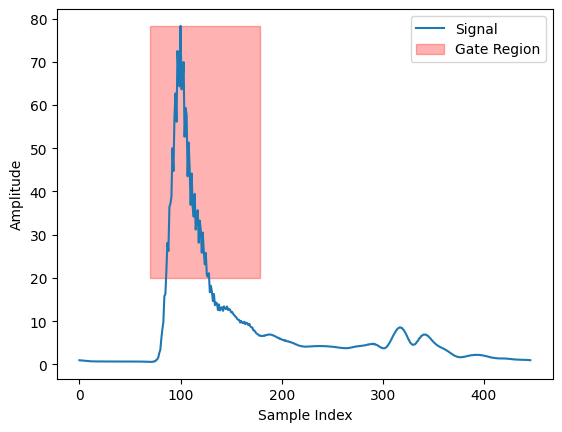

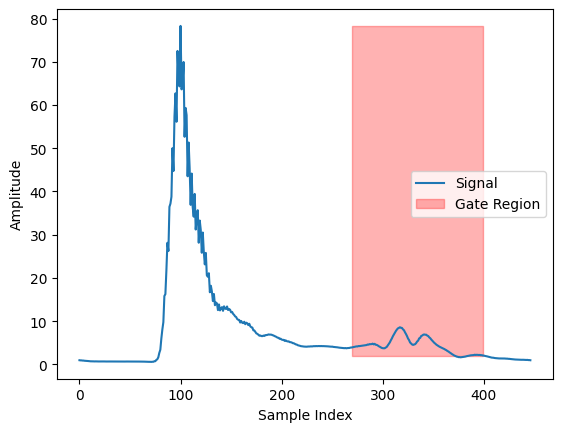

In [511]:
#select the gates
gate1 = (70,180,20)
gate2 = (270,400,2)

#plot the first gate to check
signal.plot_gate(mean_material_signal,gate1)

#plot the second gate to check
signal.plot_gate(mean_material_signal,gate2)

Text(0, 0.5, 'Height')

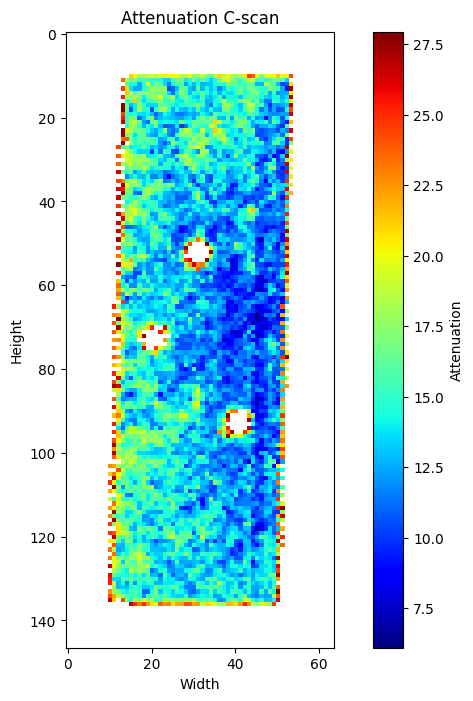

In [512]:
#compute the cscan using the selected gates
reference_amplitude = 50  # This value can be adjusted based on the data
cscan = signal.attenuation(data=envelope_volume,reference=reference_amplitude, gate1=gate1, gate2=gate2, axis=0)

plt.figure(figsize=(10, 8))
plt.imshow(cscan, cmap='jet')
plt.colorbar(label='Attenuation')
plt.title('Attenuation C-scan')
plt.xlabel('Width')
plt.ylabel('Height')

In [513]:
#save the cscan
#add to the name of the saving folder the alignmend point, the gates and the reference amplitude
saving_folder = str(saving_folder).replace('.tif',f'_align{align_point}_g1-{gate1[0]}-{gate1[1]}-{gate1[2]}_g2-{gate2[0]}-{gate2[1]}-{gate2[2]}_ref-{reference_amplitude}.tif')
print(f"Saving C-scan to: {saving_folder}")
tifffile.imwrite(saving_folder, cscan.astype(np.float32))

Saving C-scan to: \\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Fabricacion Nacho\lente\probetas\Na_07_5\Na_07_5attenuation_Cscan_align100_g1-70-180-20_g2-270-400-2_ref-50.tif
